# Exploring Warrington's Air Quality Data
---
## A2 Exploration through visualisation
### JWriggy

**data: © Crown 2020 copyright Defra via uk-air.defra.gov.uk, licenced under the [Open Government Licence (OGL)](http://www.nationalarchives.gov.uk/doc/open-government-licence/version/2/)**

**According to the World Health Organisation air pollution increases the risks of stroke, heart disease, lung cancer and respiratory disease. In fact the European Environment Agency estimated air pollution to be the cause of over *400 000* premature deaths in Europe each year. This is double the number of reported covid-19 deaths in Europe as of 14th September 2020 (ref https://www.ecdc.europa.eu/en/covid-19-pandemic). It's well known we've increased carbon dioxide levels through burning fossil fuels. I want to explore what else we're doing to the air that we breathe.**

Here I'm looking at my local, outdoor air quality in North West England, UK starting with the following questions:-
1. What does air pollution consist of?
2. What data is available?
3. How does Warrington's air quality compare with the rest of the region?
4. When is the air 'cleanest'?
5. What are the most important factors affecting local air quality?


In [1]:
# for data handling
import pandas as pd
import numpy as np

# for plots
import matplotlib.pyplot as plt 
from matplotlib.gridspec import GridSpec
from matplotlib.patches import Polygon

# for maps
import cartopy.crs as ccrs
import cartopy.feature as cfeature

## 1. What does air pollution consist of?

It turns out there are *lots* of trace chemicals and particles in the air we breathe. These include gases such as methane, carbon dioxide and ozone; and aerosols (tiny particles suspended in the air) such as of sulphates, nitrates, pollen and dusts. Here I'm going to restrict myself to some common types with man-made sources which are of concern for health:- 

- **Nitrogen dioxide (NO$_2$)** : Primary sources include vehicle exhausts, power generation with fossil fuels and wood burning. NOx gases (NO$_2$ and NO) react to form smog - the reddish brown haze often seen downwind of cities. 
- **Particulate matter (PM2.5)** : A wide range of sources eg reactions in the atmosphere involving vehicle exhausts; wind blown desert dusts, soot from log burning stoves, terpenes emitted by conifers, pollen and sea salt. The finest particles, less than 2.5 micrometres (PM2.5), are the most hazardous as they can get deep into the lungs and into the bloodstream.
- **Ground level ozone (O$_3$)**: a pale blue gas - a secondary pollutant, often resulting from complex chemical reactions between nitrogen oxides and volatile organic compounds (VOC) in the presence of sunlight. Hence levels are lowest in winter. 

[WHO - air quality and health](http://www.who.int/news-room/fact-sheets/detail/ambient-(outdoor)-air-quality-and-health)

## 2. The Data

The pollutants (NO$_2$, PM2.5 and O$_3$) are measured hourly at a number of sites throughout the UK, primarily to check compliance with EU environmental regulations. This study examines data available from the North West of England from sites designed to measure *background* levels (i.e. away from the kerbside where traffic effects are likely to dominate). About 11 years worth of NO$_2$ and PM data are available for the Warrington site whereas ozone is measured at the nearby sites of Glazebury and Liverpool Speke. The record is fairly complete but there are significant gaps and some strong seasonal effects. Modelled wind and temperature data are also available from mid 2010. 

### Getting the data

The data were downloaded as R objects from https://uk-air.defra.gov.uk/openair/R_data/ This was the most efficient method for bulk imports ie from multiple sites and years. There is a utility available to do this - importAURN, available in the openair R library on cran, courtesy of David Carslaw. (http://davidcarslaw.github.io/openair/reference/importAURN.html ) Data can also be downloaded directly as csv files using Defra's data selection tool at https://uk-air.defra.gov.uk/data/.  Individual data requests are limited to around a years worth of data per site.

*data: © Crown 2020 copyright Defra via uk-air.defra.gov.uk, licenced under the [Open Government Licence (OGL)](http://www.nationalarchives.gov.uk/doc/open-government-licence/version/2/).*

### Transforming the data
Since part of the exercise was to practice some data visualisation with python the R data objects were written out to csv files. These were read into python and aggregated into pandas dataframes for each pollutant of interest (approx 30MB total).

(See A1_DATA_WRG.ipynb for a look at the raw data)

In [2]:
# Load the aggregated data
# NB Not all pollutants are measured at all sites and there are some significant gaps in the data record. 
# All data are GMT, measured hour ending. Since python date fields run 0 - 23 hrs the hour to midnight 
# is assigned the following days date. Pollutant levels are measured in mug/m^3.
no2dat = pd.read_csv('data/no2dat.csv', index_col=["date"],  parse_dates=True,)
pm25dat = pd.read_csv('data/pm25dat.csv', index_col=["date"],  parse_dates=True,)
o3dat = pd.read_csv('data/o3dat.csv', index_col=["date"],  parse_dates=True,)

# some individual sites - 
WAR  = pd.read_csv('data/WAR20.csv',  index_col=["date"],  parse_dates=True, infer_datetime_format=True)
LVP = pd.read_csv('data/LVP20.csv', index_col=["date"],  parse_dates=True, infer_datetime_format=True)

# Meta Data
SITES = pd.read_csv('data/sites.csv', index_col=["site_name"])

In [3]:
# Styling
cols = ["#7d0000","#a10000","#d7301f","#000000","#ef6548","#faab5f","#e7ca7a","#abd9e9","#74add1","#4575b4"]
# in order of no2 mean
COLOURS = {st : cols[ix] for ix, st in enumerate(["Manchester Piccadilly", "Salford Eccles","Preston","Warrington"
                 ,"Liverpool Speke", "Wigan Centre","Wirral Tranmere","Glazebury","Blackpool Marton","Ladybower"])}

h1 = {'fontsize': 20, 'va': 'top'}
h2 = {'fontsize': 12, 'alpha': 0.8, 'va': 'top'}
h3 = {'fontsize': 10, 'alpha': 0.8}
h4 = {'fontsize': 10, 'style': 'italic','alpha': 0.8}

plt.style.use('ww.mplstyle')

## 3. How does Warrington's air quality compare with the rest of the region?

**To answer this question firstly I wanted to show where the measurement locations were. Next, long term average pollutant levels were calculated for each site to get an impression of how air quality varied across the region. Lastly, smoothed time series were plotted with reference to WHO guideline limits to reveal any trends in the data.**


The locations of Automatic Urban and Rural Network (AURN) sites monitoring background levels of air pollutants (ie away from the kerbside) in North West England are shown on the map below. The size of the marker represents the relative nitrogen dioxide (NO$_2$) level calculated from the ten year mean (2010-2019). NO$_2$ results from combustion and is often a good indicator of general air pollution. Unsurprisingly the most rural areas (Ladybower and Glazebury)  have the lowest levels of NO$_2$, and the largest urban areas (Manchester and Salford) have the highest levels. 

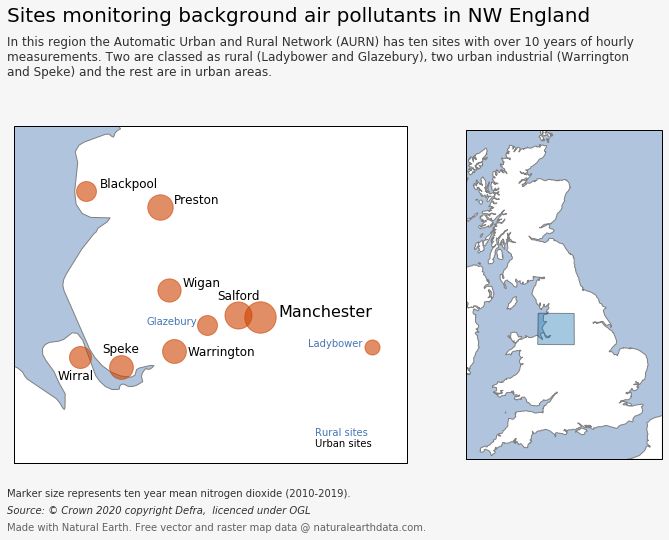

In [4]:
fig = plt.figure()
gs = GridSpec(1, 2, width_ratios=[2, 1])

# natural earth data- country borders 
ne_10m = cfeature.NaturalEarthFeature('cultural', 'admin_0_countries', '10m'
                                      , edgecolor='#808080', facecolor='#ffffff')
data_crs = ccrs.PlateCarree()
# lon, lat extent of box
x1 = -3.3; y1 = 53.1
x2 = -1.6; y2 = 53.97

## no2 10 year mean used to scale marker size  as most often linked to regulatory requirements ##
## NB the data is skewed so median may also be helpful for comparison ##
msize = [5*(no2dat['2010':'2019'].mean().loc[x])**.5 for x in SITES.index] 

#set up geo axes
ax1 = fig.add_subplot(gs[0], projection=ccrs.OSGB()) 
ax1.background_patch.set_facecolor('#B0C4DE')
ax1.set_extent([x1, x2, y1, y2], crs=data_crs)
ax1.add_feature(ne_10m)
# plot sites and labels tweaking label position as reqd
for lg, lt, name, ms in zip(SITES.lon.values, SITES.lat.values, SITES.site_label, msize):
    ax1.plot(lg, lt, 'o',color='#ce4300',ms=ms, alpha=0.6, transform=data_crs)
    if name in [u'Salford', 'Speke']:
        ax1.text(lg, lt + 0.04, name, ha='center', transform=data_crs, fontsize=12)
    elif name in [u'Glazebury','Ladybower']:
        ax1.text(lg -.04, lt, name, ha='right', color='#4575b4', transform=data_crs, fontsize=10)
    elif name in [u'Wirral']:
        ax1.text(lg +.06, lt-.06, name, ha='right', transform=data_crs, fontsize=12)
    elif name in ['Warrington']:
        ax1.text(lg + .06, lt-.01, name, ha='left', transform=data_crs, fontsize=12)
    elif name in ['Manchester']:
        ax1.text(lg + .08, lt, name, ha='left', transform=data_crs, fontsize=16)
    else:    
        ax1.text(lg + .06, lt + .01,name, ha='left', transform=data_crs, fontsize=12)
# key
ax1.text(-2,53.15,'Urban sites',color='k',fontsize=10, transform=data_crs,va='center')
ax1.text(-2,53.18,'Rural sites',color='#4575b4',fontsize=10, transform=data_crs,va='center')

# set up geoaxes 
ax2 = fig.add_subplot(gs[1], projection=ccrs.OSGB())
ax2.background_patch.set_facecolor('#B0C4DE')
ax2.set_extent([-6.3, 2.8, 49, 59], crs=data_crs)
ax2.add_feature(ne_10m) 
# plot box
xy = list(zip([x1, x2, x2, x1], [y1, y1, y2, y2]))
poly = Polygon(xy, edgecolor='k', facecolor=None, alpha = 0.4, transform=data_crs, zorder = 2)
ax2.add_patch(poly)

fig.subplots_adjust(.05,.15,.95,.75)
fig.text(.04,.95, 'Sites monitoring background air pollutants in NW England', fontdict=h1)
fig.text(.04,.9, 'In this region the Automatic Urban and Rural Network (AURN) has ten sites with over 10 years' +
        ' of hourly\nmeasurements. Two are classed as rural (Ladybower and Glazebury)'+
         ', two urban industrial (Warrington\nand Speke) and the rest are in urban areas.', fontdict=h2)
fig.text(.04,.1,'Marker size represents ten year mean nitrogen dioxide (2010-2019).', fontdict=h3)
fig.text(.04,.07,"Source: © Crown 2020 copyright Defra,  licenced under OGL", fontdict=h4) 
fig.text(.04,.04,"Made with Natural Earth. Free vector and raster map data @ naturalearthdata.com.", alpha=0.6) 

plt.savefig("vis/F1_no2_aurn_sitemap.png")
plt.show()

Ten year means were calculated for air pollutants measured at these 10 sites as shown in the barcharts below. Note not all pollutants are measured at all sites and gaps in the data record may distort the results slightly. 

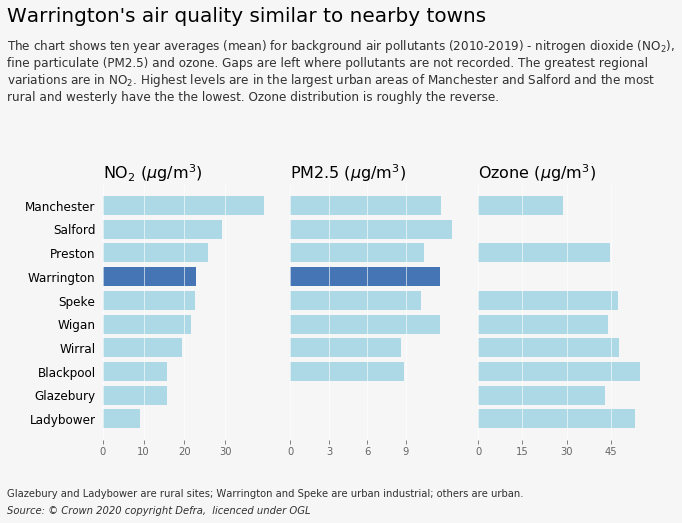

In [5]:
def barplot_means(ax, df, title="multi year means"):
    # plot barchart ordered by no2 mean
    ordered_sites = SITES.reindex(no2dat.mean().sort_values().index)
    _mean = pd.Series(df.mean(), name = "_mean")
    dat = ordered_sites.join(_mean,  how='left')
    dat['colour'] = ["lightblue" for row in dat.index]
    dat.at['Warrington','colour'] = "#4575b4"
    
    ax.tick_params(axis='y', labelsize=12, colors='k')  
    ax.set_title(title, loc='left')
    ax.barh(np.arange(len(dat)), dat._mean.values, color=dat.colour,tick_label=dat.site_label)
    ax.grid(True, 'both', 'x', lw=1, c='w')
    ax.tick_params('x', bottom=True)
    return(ax)

fig, (ax1,ax2,ax3) = plt.subplots(1,3, sharey=True, subplot_kw=dict(frameon=False))
# date range YEAR1 - YEAR2 inclusive
YEAR1 = '2010'; YEAR2 = '2019'

ax1 = barplot_means(ax1,no2dat[YEAR1:YEAR2],title='NO$_2$ ($\mu$g/m$^3$)')
ax1.set_xticks([0,10,20,30])
ax2 = barplot_means(ax2,pm25dat[YEAR1:YEAR2],title='PM2.5 ($\mu$g/m$^3$)')
ax2.set_xticks([0,3,6,9])
ax3 = barplot_means(ax3,o3dat[YEAR1:YEAR2],title='Ozone ($\mu$g/m$^3$)')
ax3.set_xticks([0,15,30,45])

fig.tight_layout(rect=[.05, .15, .95, 0.7])
fig.text(.04,.95, 'Warrington\'s air quality similar to nearby towns', fontdict=h1)
fig.text(.04,.9, 'The chart shows ten year averages (mean) for background air pollutants ('  +YEAR1 +'-' +YEAR2 + ') - nitrogen dioxide (NO$_2$),\n' +
         'fine particulate (PM2.5) and ozone. Gaps are left where pollutants are not recorded. The greatest regional\n' +
         'variations are in NO$_2$. Highest levels are in the largest urban areas of Manchester and Salford and the most\n'+
         'rural and westerly have the the lowest. Ozone distribution is roughly the reverse.', fontdict=h2)
fig.text(.04,.1, 'Glazebury and Ladybower are rural sites; Warrington and Speke are urban industrial; others are urban.', fontdict=h3)
fig.text(.04,.07,"Source: © Crown 2020 copyright Defra,  licenced under OGL", fontdict=h4) 

plt.savefig("vis/F2_no2_pm_o3_means.png")                    
plt.show()

Of these three the greatest regional variation can be seen in nitrogen dioxide (NO$_2$) levels; Manchester Piccadilly had a 10 year average over 4 times that of Ladybower - the most remote site. Warrington had similar background NO$_2$ to other urban areas in the region eg Wigan and Liverpool Speke. Just 7.5 miles due northeast of Warrington at the rural Glazebury site, average NO$_2$ had dropped by about 30%. The most rural (Ladybower) and the most westerly (The Wirral and Blackpool) sites had the lowest levels.

Fine particulates (PM2.5) weren't measured at the rural sites but it can be seen that the most westerly sites again have the lowest levels. 

Ozone is not measured in Warrington but the nearby urban industrial area of Liverpool Speke had similar NO$_2$ levels and may indicate likely levels. The largest urban areas (Manchester and Salford) had the lowest mean ozone, probably related to the depletion of ozone by nitrous oxides; Ladybower and Blackpool the highest. However Glazebury - also rural though less remote - also had quite low mean ozone levels.

### Trends in pollution levels with respect to World Health Organisation guidelines

There are strong seasonal variations in air pollution levels so smoothed time series of NO$_2$, PM2.5 and ozone have been plotted for both urban and rural sites across the north west of England. The aim is to reveal underlying trends over the decade and to suggest how the different sites compare. For NO$_2$ and PM2.5 each point is an average of the preceding 365 daily means and the WHO guideline limit for the annual mean is shown for context. Since there is no WHO annual guideline for ozone the number of days exceeding the daily guideline has been plotted instead. Colours used for each site have been kept the same across the plots to aid comparison.<br><br>*To minimise artefacts due to missing data, thresholds were set of 20 hours per daily mean and 75% of daily means per annual mean.*

[WHO - air quality and health](http://www.who.int/news-room/fact-sheets/detail/ambient-(outdoor)-air-quality-and-health)

### NO$_2$

In [6]:
def ts_plot(ax, df = no2dat, title="Trends in NO$_2$ in North West England",y_pos=[]):
# time series plot of 365 day rolling means
# only use daily means with > 20 hours recorded to avoid skews due to diurnal variations when missing data
# threshold 0.75*365 = 273 days data - possible skews due to seasonal variations when missing data
    grouped = df.resample('D')
    rm = grouped.mean()[grouped.count()>20].rolling(365, center=False, min_periods=273).mean() 
    x = rm.index.values
    sites = df.columns.values
    
    # start plot at end of first complete year of data
    ax.set_xlim(pd.datetime(2009,12,31),pd.datetime(2020,9,1)) 
    # draw lines and labels  
    x_pos = pd.datetime(2020,12,1)
    for ix, site in enumerate(sites):
        if site != 'Warrington':
            ax.text(x_pos, y_pos[ix], site, fontsize=10, color=COLOURS[site])
            ax.plot(x, rm[site].values, lw=2, color = COLOURS[site], alpha = 0.8)
    ax.plot(x, rm['Warrington'].values, lw=6, color = 'k')
    ax.text(x_pos, y_pos[-1], 'Warrington', fontsize = 16, color = 'k')  
    
    for i in range(2011,2020,2):
        ax.axvspan(pd.datetime(i,1,1),pd.datetime(i,12,31), facecolor='k', alpha=0.04)
    ax.set_xticks([pd.datetime(i,6,15) for i in range(2010,2021,2)]) # centre the year label
    ax.grid(True, 'major', 'y', ls='-', lw=.5, c='k', alpha=.5)
    
    plt.gcf().text(.04,.95, title, fontdict=h1)
    plt.gcf().text(.04,.1,'Smoothed time series: Each point is an average of the preceding 365 days.', fontdict=h3)
    plt.gcf().text(.04,.07,'The WHO guideline limit is for the annual mean.',fontdict=h3)
    plt.gcf().text(.04,.04,"Source: © Crown 2020 copyright Defra,  licenced under OGL", fontdict=h4)
    return(ax)


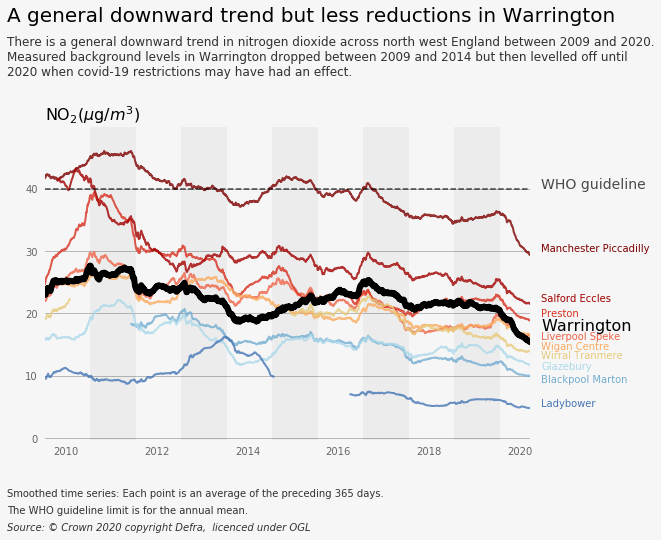

In [7]:
# NO2 365 day rolling means
fig, ax = plt.subplots(subplot_kw=dict(frameon=False))
ax.set_ylim(-0.25, 50)
ax = ts_plot(ax,df=no2dat,title='A general downward trend but less reductions in Warrington'
             ,y_pos=[9,11,5,15.8,30,19.5,22,0,14.3,12.8,17.2] )
ax.set_yticks([0,10,20,30,40])
ax.axhline(40, color='k', ls='--', alpha=0.7)
ax.text(pd.datetime(2020,12,1), 40, 'WHO guideline', fontsize = 14, alpha=0.7)
ax.set_title('NO$_2$($\mu$g/$m^3$)', loc='left')

fig.text(0.04,0.9,'There is a general downward trend in nitrogen dioxide across north west England between 2009 and 2020.\n'+
         'Measured background levels in Warrington dropped between 2009 and 2014 but then levelled off until\n' +
         '2020 when covid-19 restrictions may have had an effect.', fontdict=h2)
fig.tight_layout(rect=[0.05, 0.15, .95, 0.8]) 
fig.set_tight_layout(tight=None)

plt.savefig("vis/F3_no2_rolling_annual_means.png")
plt.show()

The overall picture is of a downward trend in NO$_2$ levels. However the Warrington site seems to be an exception with a much flatter curve until the start of 2020. Many features are common to all sites, for example the downward trend winter 2013/2014 and the strong upward trend winter 2016/2017. These are likely to relate to regional weather effects -  strong winds disperse pollutants, temperature inversions trap pollutants at ground level and cold winters result in more fuel burning for heating. The drop at all sites in 2020 is likely in part to result from reduced traffic due to covid19.

Only the Manchester and Salford sites have breached the WHO guideline for annual mean NO$_2$ levels of 40 $\mu$g/$m^3$. Of course these sites represent *background* levels and at the roadside levels are likely to be considerably higher. For example in 2017 the annual mean NO$_2$ at an urban traffic site in Halton was 34.7 $\mu$g/$m^3$ whereas at the nearby Warrington site, placed away from the main road, it was only 21.0. Road traffic is clearly a significant source of NO$_2$. In fact, a quick look at the European Environment Agency Air Quality Statistics reveals many urban traffic sites with 2017 annual means of over 50 $\mu$g/$m^3$ NO$_2$ in cities across the continent such as London, Paris, Brussels, Stuttgart and Frankfurt. Background levels at many major cities are comparable to that at Manchester in 2017 ie in the mid 30s. ( Ref [European Environment Agency Statistics](https://www.eea.europa.eu/data-and-maps/dashboards/air-quality-statistics) )
  
### PM2.5

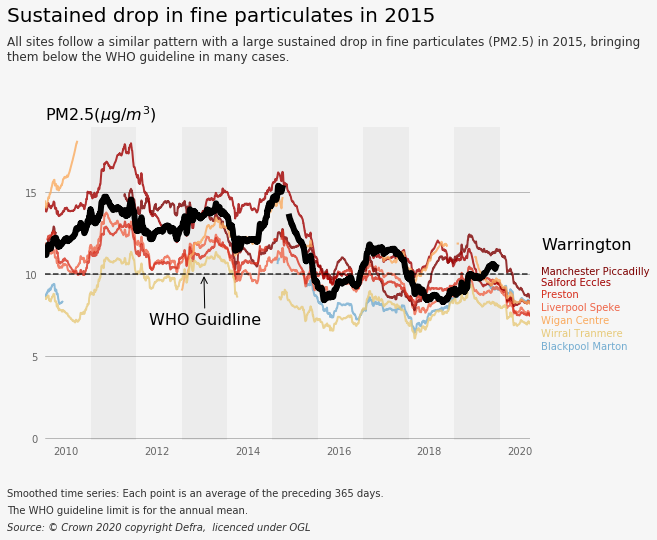

In [8]:
# PM2.5 365 day rolling means
fig, ax = plt.subplots(subplot_kw=dict(frame_on=False))
ax.set_ylim(-0.1, 19)
ax = ts_plot(ax,df=pm25dat,title='Sustained drop in fine particulates in 2015' 
             ,y_pos=[5.4,7.8,10,8.6,9.3,11,7,6.2,11.5] )
ax.set_yticks([0,5,10,15])
ax.axhline(10, color='k', ls='--', alpha=0.8)
ax.set_title('PM2.5($\mu$g/$m^3$)', loc='left')
ax.annotate('WHO Guidline',xy=(pd.datetime(2013,6,30), 10), xycoords='data',
            xytext=(-55, -50), textcoords='offset points',fontsize=16,
            arrowprops=dict(arrowstyle="->",connectionstyle="arc3"))
fig.text(0.04,0.9,'All sites follow a similar pattern with a large sustained drop in fine particulates (PM2.5) in 2015, bringing\n' +
         'them below the WHO guideline in many cases. ', fontdict=h2)
fig.tight_layout(rect=[0.05, 0.15, .95, 0.8]) 

plt.savefig("vis/F4_pm25_rolling_annual_means.png", dpi=90)
plt.show()

The PM 2.5 curves are more tightly clustered. Many features are shared with the NO$_2$ curves, for example the drop in winter 13/14 and rise winter 16/17. At these times regional weather effects may have either dispersed pollutants or allowed them to build up affecting both NO$_2$ and particulates. 

Levels of PM 2.5 appear to have dropped off markedly in 2015 bringing them below the WHO guideline in many cases. Note that the EU target value at 25$\mu$gm$^3$ is considerably higher then the WHO guideline limit for health. Again it should be noted that the measurements represent background levels.

### Ozone
Ground level ozone is strongly affected by sunlight levels. The WHO guideline limit for health relates to the maximum daily 8 hour mean which is set at 100$\mu$gm$^3$. The UK objective is to exceed this on fewer than 10 days per year. (The EU limit is less strict) To reveal possible trends the number of days exceeding the WHO guideline have been plotted below, averaged over 3 years to smooth out interannual variability. 

[UK Air Quality Objectives](https://uk-air.defra.gov.uk/assets/documents/Air_Quality_Objectives_Update.pdf)


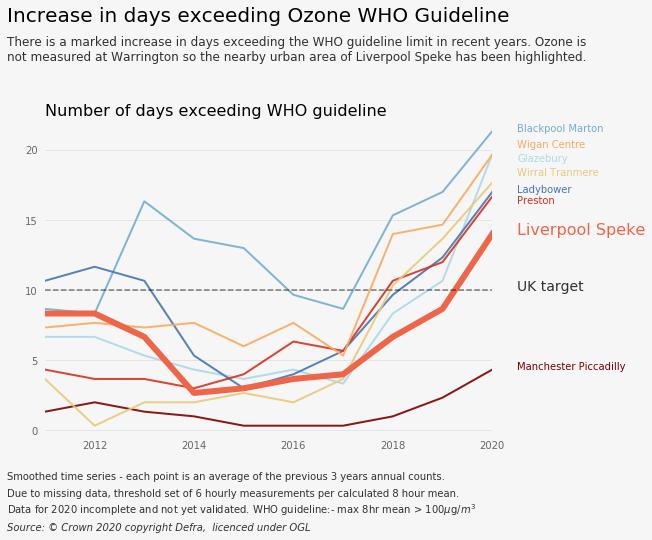

In [9]:
# Uk objective : ozone max daily 8 hr mean not to exceed 100 more than 10 times a year.
# Use at least 6 measurements per 8 hour period
h8m = o3dat.rolling('8H',min_periods=6).mean()  
hi = h8m.resample('D').max()>100
count = hi.groupby([hi.index.year]).sum()
# each point is average of previous 3 years
rm =  count.rolling(3, center=False).mean()[2:]
x = rm.index.values
sites = o3dat.columns.values

#create plot
fig,ax = plt.subplots(subplot_kw=dict(frameon=False))
ax.set_ylim(-0.25, 22)
ax.set_xlim(2011,2020)
# lines & labels 
x_pos = 2020.5
y_offsets = [0,-.5,0,0,0,-.5,0.5,.5]
for ix, site in enumerate(sites):
    if site != 'Liverpool Speke':
        y_pos = rm[site].iloc[-1] + y_offsets[ix]
        ax.text(x_pos, y_pos, site, fontsize=10, color=COLOURS[site])
        ax.plot(x, rm[site].values, lw=2, color = COLOURS[site], alpha = 0.9)
# emphasise a site
site = "Liverpool Speke"
ax.text(x_pos, rm[site].iloc[-1], site, fontsize=16, color=COLOURS[site], alpha=1)
ax.plot(x, rm[site].values, lw=6, color = COLOURS[site], alpha = 1)    

# Annotate
ax.grid(True, 'major', 'y', ls='-', lw=.5, alpha=.5)
ax.axhline(10, color='k', ls='--', alpha=0.5)
ax.text(x_pos, 10, 'UK target', fontsize = 14, alpha=.8)
ax.set_title('Number of days exceeding WHO guideline',loc='left')
ax.set_yticks([0,5,10,15,20])
ax.set_xticks(np.arange(2012,2021,2))

fig.tight_layout(rect=[0.05, 0.16, .95, 0.8]) 
fig.text(.04,.95,'Increase in days exceeding Ozone WHO Guideline ', fontdict=h1 )
fig.text(.04,.9,'There is a marked increase in days exceeding the WHO guideline limit in recent years. Ozone is\nnot measured at ' +
         'Warrington so the nearby urban area of Liverpool Speke has been highlighted.',fontdict=h2)
fig.text(.04,0.13,"Smoothed time series - each point is an average of the previous 3 years annual counts.", fontdict=h3)
fig.text(.04,0.1,"Due to missing data, threshold set of 6 hourly measurements per calculated 8 hour mean.", fontdict=h3)
fig.text(.04,0.07,"Data for 2020 incomplete and not yet validated. WHO guideline:- max 8hr mean > 100$\mu$g/$m^3$", fontdict=h3)
fig.text(.04,0.04,"Source: © Crown 2020 copyright Defra,  licenced under OGL", fontdict=h4)

plt.savefig("vis/F5_o3_WHO_guideline_exceedences.png",dpi=90)
plt.show()

There is a marked increase in days exceeding the 100$\mu$gm$^3$ guideline in recent years although it is hard to say whether this is part of a longer term trend or just due to a couple of unusually sunny years. Glazebury appears to have had an unusually large increase in 2020 which could warrant further investigation. Note the 2020 data is incomplete and not yet all validated.

### Summary
>In summary air quality is quite variable year to year. Warrington's background air quality is broadly similar to other towns in the North West of England. It seems possible that moving west or to a more rural region might reduce NO$_2$ exposure but could also result in higher ozone. Of the two, ozone levels appear more likely to breach health guideline limits. Background fine particulates vary less across the region. Of course variations due to proximity to sources such as busy roads or log burning stoves may far outweigh the variations in general background air quality.

## 4. When is the air 'cleanest'

**I was curious to know if there might be better times to exercise outdoors if particularly sensitive to air pollutants. Is there a strong 'rush hour' spike?**

To get a view on how air quality varies throughout the day and over the year I split ten years of local background pollutant data into month categories and averaged by hour (GMT). The resultant plots show how morning and afternoon peaks vary throughout the year. Note British Summer time is 1 hour later than GMT and runs from late March to late October. So any rush hour effects would appear 1 hour earlier in GMT.

In [10]:
def diurnal_plot(ax, df = no2dat, site='Warrington', title="Diurnal Variation (GMT)", y_offsets=[0,0,0,0,0,0]):
# plot 10 years of pollutant data for a particular site averaged by month and hour of day
    df = df['2010':'2019']
    month_hrs = df[site].groupby([df.index.month, df.index.hour]).mean()
    cols = ["#4575b4","#abd9e9","#a10000","#7d0000","#ef6548","#74add1"]
    x = range(24)
    labels = ['January','March','May','July','September','November']
    for ix, mon in enumerate([1,3,5,7,9,11]):
        ax.plot(x, month_hrs[mon], lw=3, color = cols[ix], alpha = 0.9)
        ax.text(24, month_hrs[mon,23] + y_offsets[ix] , labels[ix], fontsize=12, color=cols[ix])
    for ix, mon in enumerate([12,2,4,6,8,10]):
        ax.plot(x, month_hrs[mon], lw=1, color = cols[ix], alpha = 0.6)
    
    # annotate
    ax.set_xticks([0,4,8,12,16,20])
    ax.set_xticklabels(['00:00','04:00','08:00','12:00','16:00','20:00'])
    ax.grid(True, 'major', 'both', ls='--', lw=.5, c='k', alpha=.2)
    
    plt.gcf().text(.04, .95, title, fontdict=h1)
    plt.gcf().text(.04,0.1,"Hourly means, 2010 - 2019, measurements are hour ending, GMT",fontdict=h3)
    plt.gcf().text(.04,0.04,"Source: © Crown 2020 copyright Defra,  licenced under OGL", fontdict=h4)  
    return(ax)

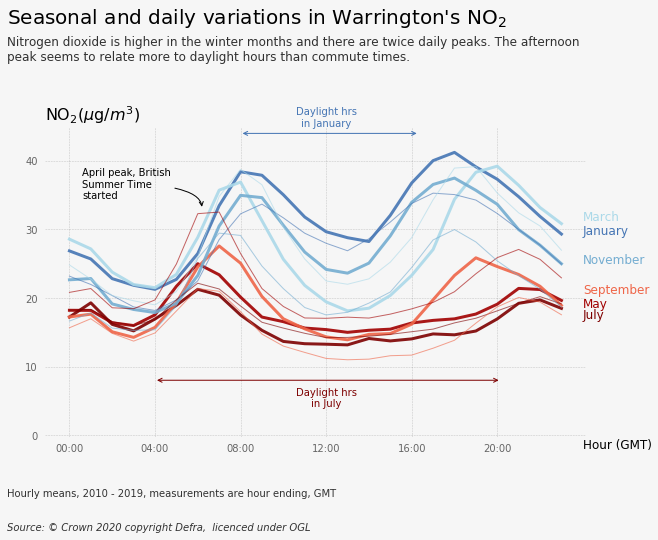

In [11]:
fig, ax = plt.subplots(subplot_kw=dict(frameon=False))
# no2
ax.set_ylim([-.25,45])
ax.set_yticks([0,10,20,30,40])
ax = diurnal_plot(ax,no2dat,site='Warrington',
                  title='Seasonal and daily variations in Warrington\'s NO$_2$', y_offsets=[0,.5,-1,-1.5,1.8,0])
ax.set_title('NO$_2$($\mu$g/$m^3$)', loc='left')
ax.text(24, -2, 'Hour (GMT)', fontsize=12)
ax.annotate('April peak, British\nSummer Time\nstarted',xy=(6.2, 33), xycoords='data',fontsize=10,
            xytext=(-120, 10), textcoords='offset points',
            arrowprops=dict(arrowstyle="->",connectionstyle="angle3,angleA=0,angleB=-90"))
ax.annotate("",xy=(4, 8), xycoords='data',
            xytext=(20.16, 8), textcoords='data',
            arrowprops=dict(arrowstyle="<->",connectionstyle="arc3",color="#7d0000"))
ax.annotate("",xy=(8, 44), xycoords='data',
            xytext=(16.33, 44), textcoords='data',
            arrowprops=dict(arrowstyle="<->",connectionstyle="arc3",color="#4575b4"))
ax.text(12,7,'Daylight hrs\nin July', color="#7d0000", fontsize=10, ha='center', va='top')
ax.text(12,45,'Daylight hrs\nin January', color="#4575b4", fontsize=10, ha='center' )

fig.tight_layout(rect=[.05, .15, .95, 0.8]) 
fig.text(0.04,.9,'Nitrogen dioxide is higher in the winter months and there are twice daily peaks. The afternoon\n'+
         'peak seems to relate more to daylight hours than commute times.', fontdict=h2)
plt.savefig("vis/F6_Warrington_no2_diurnal_variation.png",dpi=90)
plt.show()

There are clear seasonal differences with higher levels of NO$_2$ in the winter months and twice daily peaks. March has the greatest diurnal variation with an evening 10 year average peak of about 39 $\mu$g/$m^3$ at 8pm contrasting with a minimum just half that at 1pm. Conversely the summer months exhibit the smallest variations. The afternoon peaks vary between about 6pm in January and 10 pm GMT in July appearing to correlate more to the changing length of daylight hours than to the peak commute times. Possible explanations are the breakdown of NO$_2$ in sunlight during ozone formation and reduced dispersion overnight due to more stable atmospheric conditions. 


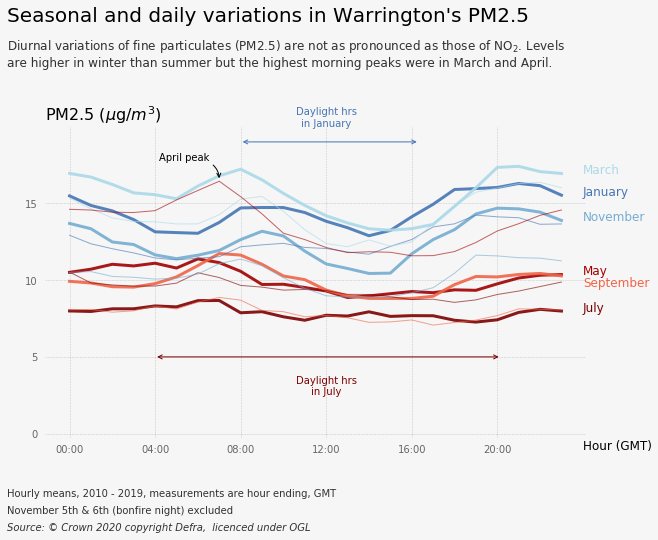

In [12]:
fig, ax = plt.subplots(subplot_kw=dict(frameon=False))
# pm2.5
ax.set_ylim([-.25,20])
ax.set_yticks([0, 5,10,15])
# exclude bonfire night (nov 5th and 6th) as extreme values skew november means
df = pm25dat[~((pm25dat.index.month ==11) & ((pm25dat.index.day ==5) | (pm25dat.index.day ==6)))]
ax = diurnal_plot(ax,df,site='Warrington',
                  title='Seasonal and daily variations in Warrington\'s PM2.5', y_offsets=[0,0,0,0,-.7,0])
ax.set_title('PM2.5 ($\mu$g/$m^3$)', loc='left')
ax.text(24, -1, 'Hour (GMT)', fontsize=12)
ax.annotate('April peak',xy=(7, 16.5), xycoords='data',fontsize=10,
            xytext=(-60, 20), textcoords='offset points',
            arrowprops=dict(arrowstyle="->",connectionstyle="angle3,angleA=0,angleB=-90"))
ax.annotate("",xy=(4, 5), xycoords='data',
            xytext=(20.16, 5), textcoords='data',
            arrowprops=dict(arrowstyle="<->",connectionstyle="arc3",color="#7d0000"))
ax.annotate("",xy=(8, 19), xycoords='data',
            xytext=(16.33, 19), textcoords='data',
            arrowprops=dict(arrowstyle="<->",connectionstyle="arc3",color="#4575b4"))
ax.text(12,3.8,'Daylight hrs\nin July', color="#7d0000", fontsize=10, ha='center', va='top')
ax.text(12,20,'Daylight hrs\nin January', color="#4575b4", fontsize=10, ha='center' )

fig.tight_layout(rect=[.05, .15, .95, 0.8]) 
fig.text(0.04,.9,'Diurnal variations of fine particulates (PM2.5) are not as pronounced as those of NO$_2$. Levels\n' +
         'are higher in winter than summer but the highest morning peaks were in March and April.', fontdict=h2)
fig.text(0.04,0.07,'November 5th & 6th (bonfire night) excluded',fontdict=h3)
plt.savefig("vis/F7_Warrington_pm25_diurnal_variation.png",dpi=90)
plt.show()

Bonfire night (November 5th) is associated with very high levels of particulates and distorted the average evening November peak. It has therefore been excluded from this analysis. 

Diurnal variations in levels of fine particulates at Warrington are not as great as those of NO$_2$. Again average levels are higher in winter than summer but the highest morning peaks here are in March and April. This may be linked to the condensation of nitrates transported from the continent in early spring. Twice daily peaks in PM2.5 can be seen in winter but there is only a small morning one in summer so local commuter traffic may not be a very significant source. Domestic heating is likely to contribute towards the winter evening peak at around 8pm. 

https://uk-air.defra.gov.uk/assets/documents/reports/cat11/1212141150_AQEG_Fine_Particulate_Matter_in_the_UK.pdf

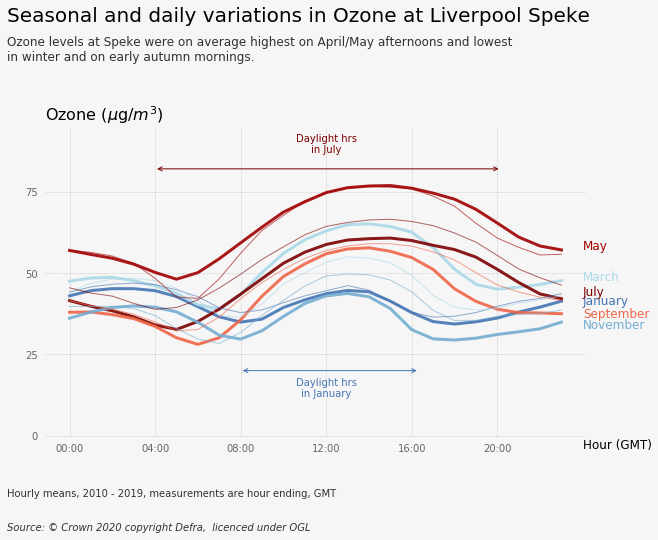

In [13]:
fig, ax = plt.subplots(subplot_kw=dict(frameon=False))
# ozone
ax.set_ylim([-.25,95])
ax.set_yticks([0,25,50,75])
ax = diurnal_plot(ax,o3dat,site='Liverpool Speke',
                  title='Seasonal and daily variations in Ozone at Liverpool Speke', y_offsets=[-1,0,0,1,-1,-2])
ax.set_title('Ozone ($\mu$g/$m^3$)', loc='left')
ax.text(24, -4, 'Hour (GMT)', fontsize=12)
ax.annotate("",xy=(4, 82), xycoords='data',
            xytext=(20.16, 82), textcoords='data',
            arrowprops=dict(arrowstyle="<->",connectionstyle="arc3",color="#7d0000"))
ax.annotate("",xy=(8, 20), xycoords='data',
            xytext=(16.33, 20), textcoords='data',
            arrowprops=dict(arrowstyle="<->",connectionstyle="arc3",color="#4575b4"))
ax.text(12,87,'Daylight hrs\nin July', color="#7d0000", fontsize=10, ha='center')
ax.text(12,18,'Daylight hrs\nin January', color="#4575b4", fontsize=10, ha='center',va='top' )

fig.tight_layout(rect=[.05, .15, .95, 0.8]) 
fig.text(0.04,.9,'Ozone levels at Speke were on average highest on April/May afternoons and lowest\n'+
         'in winter and on early autumn mornings.', fontdict=h2)

plt.savefig("vis/F8_Speke_ozone_diurnal_variation.png",dpi=90)
plt.show()

Since ozone isn't measured at the Warrington site daily variations at the nearby urban site of Liverpool Speke have been plotted to indicate how Warrington's ozone levels might vary. Levels are on average highest on April/May afternoons and lowest in winter and on early autumn mornings.

### Summary
>On average the 'cleanest' air in terms of NO$_2$ and fine particulates occurs in summer (May - September). However ozone levels can be high in May, particularly in the afternoons. The rush hour spike seems more of a wintertime phenomenon. In winter the 'cleanest' air is in the middle of the day between about 11 am and 3 pm and ozone levels tend to be low. NB these comments relate only to *average background* conditions. Temporary weather effects and proximity to local sources are likely to significantly effect personal exposure and there is considerable variation day to day.

## 5. What are the most important factors affecting local air quality?

**I wanted to explore the relative importance of various factors that might influence air quality - For example how does a weekday with commuter traffic compare with a Sunday with light traffic? How does a windy day which might disperse pollutants compare with a still one? Is wind direction important? Are cold winter days which might result in more domestic heating very different to warm summer ones?** 

To gain some insight the pollutant data were split into categories and the quantiles calculated. Each bar plotted represents the inter quartile range ie the middle three quarters of the hourly measurements in that category. The median values are also shown, connected by black lines.

In [14]:
def factors_iqr(SITE = WAR, POL = 'no2'):
# split data into categories and create dataframe of 25, 50 and 75 percentiles for each category
# NB fewer records in 'windy' category at Speke than Warrington; 3x as many SW as NE
    X = pd.DataFrame({"pol" : SITE[POL] , 'temp' : SITE['temp'], 'ws' : SITE['ws'] , 'wd' : SITE['wd']})
    # create category for wind directions - 90 degree intervals
    X['wd_cat'] = pd.cut(X.wd,[0,90,180,270,361], labels = ['NE','SE','SW','NW'])    
    ## season categories , 1 = winter (DJF) etc
    X['season'] = [(month%12 + 3)//3 for month in X.index.month]
    
    #print("Record counts:")
    #print("windy", X.pol[(X.ws > 6.5)].count() )
    #print("still", X.pol[(X.ws < 2.5)].count() )
    #print("NE", X.pol[(X.wd_cat == 'NE')].count())
    #print("SE", X.pol[(X.wd_cat == 'SE')].count())
    #print("SW", X.pol[(X.wd_cat == 'SW')].count())
    #print("NW", X.pol[(X.wd_cat == 'SW')].count())
    
    qntls = pd.DataFrame()
    qntls[POL] = X.pol.quantile([.25,.50,.75])
    qntls['Winter'] = X.pol[X.season==1].quantile([.25,.50,.75])
    qntls['Spring'] = X.pol[X.season==2].quantile([.25,.50,.75])
    qntls['Summer'] = X.pol[X.season==3].quantile([.25,.50,.75])
    qntls['Autumn'] = X.pol[X.season==4].quantile([.25,.50,.75])
    qntls['Sun'] = X.pol[(X.index.dayofweek == 6)].quantile([.25,.50,.75])
    qntls['Fri'] = X.pol[(X.index.dayofweek == 4)].quantile([.25,.50,.75])

    qntls['windy'] = X.pol[(X.ws > 6.5)].quantile([.25,.50,.75])
    qntls['still'] = X.pol[(X.ws < 2.5)].quantile([.25,.50,.75])
    qntls['NE'] = X.pol[(X.wd_cat == 'NE')].quantile([.25,.50,.75])
    qntls['SE'] = X.pol[(X.wd_cat == 'SE')].quantile([.25,.50,.75])
    qntls['SW'] = X.pol[(X.wd_cat == 'SW')].quantile([.25,.50,.75])
    qntls['NW'] = X.pol[(X.wd_cat == 'NW')].quantile([.25,.50,.75])
    
    return(qntls)

In [15]:
def plot_fac_iqrs(ax, qntls, pol_label='NO$_2$',yticks=[0,40]
                  , facs = [['still','windy'],['SE','NW'],['NE','SW']]):
# plot interquartile ranges to compare factors 
    cols = ["#4575b4", "#a10000"]
    ax.set_xlim(0,2*len(facs))
    ax.tick_params(axis='x', which='both', bottom=False, labelbottom=False)
    ax.set_title(pol_label + ' ($\mu$g/$m^3$)', loc='left' )
    for n,fac in enumerate(facs):
        factor1=fac[1]
        factor2=fac[0]
        ax.text(2*n+0.5, 0,factor1, fontsize = 10, color=cols[0], ha='center' )
        ax.text(2*n+1.5, 0,factor2, fontsize = 10, color=cols[1], ha='center' )
        ax.plot([2*n+0.5,2*n+0.5,2*n+0.5], qntls[factor1].values, lw=3, color = cols[0], alpha=0.7)
        ax.plot([2*n+1.5,2*n+1.5,2*n+1.5], qntls[factor2].values, lw=3, color = cols[1], alpha=0.7)
        ax.plot([2*n+0.5,2*n+1.5],[qntls[factor1][0.5], qntls[factor2][0.5]], lw=2, alpha=1, color='k')
        ax.scatter([2*n+0.5,2*n+1.5],[qntls[factor1][0.5], qntls[factor2][0.5]],s=60, color='k')
    ax.set_yticks(yticks)
    ax.axhline(qntls.iloc[1,0], color='k', ls='--', alpha=0.3)
        
    return(ax)

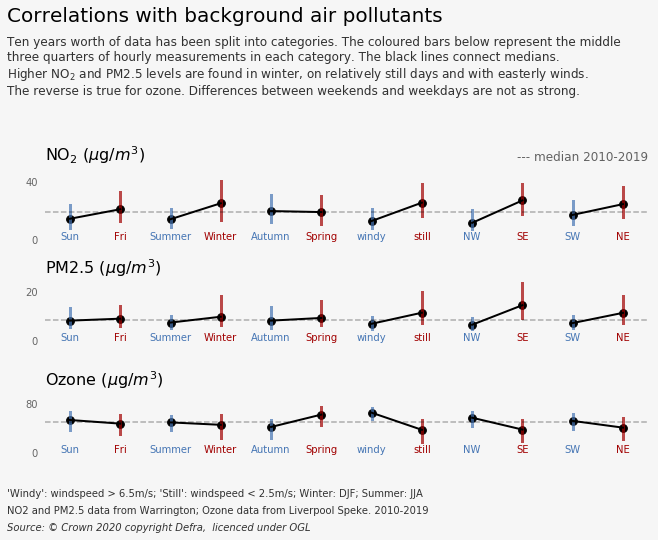

In [16]:
fig, (ax1,ax2,ax3) = plt.subplots(3,1,subplot_kw=dict(frameon=False))

df = WAR['2010':'2019']
qntls = factors_iqr(df, 'no2')
ax1 = plot_fac_iqrs(ax1,qntls,pol_label='NO$_2$', yticks=[0,40]
        ,facs = [['Fri','Sun'],['Winter','Summer'],['Spring','Autumn'],['still','windy'],['SE','NW'],['NE','SW']])
ax1.set_ylim(0,50)
ax1.set_title('--- median 2010-2019', alpha=0.6,fontsize=12, loc='right')

qntls = factors_iqr(df, 'pm2.5')
ax2 = plot_fac_iqrs(ax2,qntls,pol_label='PM2.5',yticks=[0,20] 
         ,facs = [['Fri','Sun'],['Winter','Summer'],['Spring','Autumn'],['still','windy'],['SE','NW'],['NE','SW']])
ax2.set_ylim(-5,25)

df = LVP['2010':'2019']
qntls = factors_iqr(df, 'o3')
ax3 = plot_fac_iqrs(ax3,qntls,pol_label='Ozone', yticks=[0,80]
        ,facs = [['Fri','Sun'],['Winter','Summer'],['Spring','Autumn'],['still','windy'],['SE','NW'],['NE','SW']])
ax3.set_ylim(-20,100)

fig.tight_layout(rect=[.05, .13, .95, 0.73]) 
fig.text(.04,.95, 'Correlations with background air pollutants', fontdict=h1)
fig.text(.04, .9, 'Ten years worth of data has been split into categories. The coloured bars below represent the middle\nthree quarters of'+
         ' hourly measurements in each category. The black lines connect medians.\n' +
         'Higher NO$_2$ and PM2.5 levels are found in winter, on relatively still days and with easterly winds.\n'+
         'The reverse is true for ozone. Differences between weekends and weekdays are not as strong.', fontdict=h2)
fig.text(.04, .1, '\'Windy\': windspeed > 6.5m/s; \'Still\': windspeed < 2.5m/s; Winter: DJF; Summer: JJA', fontdict=h3)
fig.text(.04, .07, 'NO2 and PM2.5 data from Warrington; Ozone data from Liverpool Speke. 2010-2019', fontdict=h3)
fig.text(0.04,0.04,"Source: © Crown 2020 copyright Defra,  licenced under OGL", fontdict=h4)  

plt.savefig("vis/F9_WAR_correlations.png", dpi=90)
plt.show()

Of these factors wind direction and speed have the most striking relationship with background air pollution levels in Warrington. Highest levels of NO$_2$ and PM2.5 are associated with still days and easterly winds, the reverse being true of ozone. Winter is the season with the widest range of pollutant measurements and these tend to be higher than other seasons for NO$_2$ and PM2.5. Ozone is highest in Spring. Weekday appears to have little impact on fine particulates but NO$_2$ tends to drop off on Sundays with respect to the working week. 

To explore the impact of winds on the dispersion of local pollutants I looked at the particulate data around bonfire night (November 5th) together with modelled wind speed data for Warrington, 2010-2019. 2012 had the lowest mean modelled wind speed averaging about 1m/s for the 12 hours from 6pm on November 5th. 2016 had the highest at 7.3 m/s.

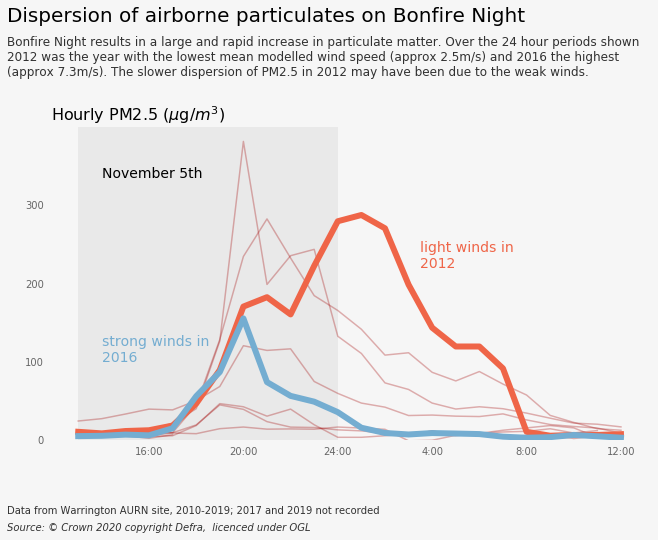

In [17]:
# subset data for 24 hours of interest
dat = pd.DataFrame()
years = range(2010,2020)
for year in years :
    dat[str(year)] = WAR['pm2.5'][str(year)+'-11-5 13:00:00' : str(year)+'-11-6 12:00:00'].values

fig,ax = plt.subplots(subplot_kw=dict(frameon=False))
ax.set_ylim(0,400)
# minor lines
for year in years: ax.plot(dat[str(year)], color = "#a10000", alpha=.3)
# major lines 
for year, col in zip([2012, 2016],["#ef6548","#74add1"]):
    ax.plot(dat[str(year)], lw=6, color = col)
ax.text(14.5,220,'light winds in\n2012', color="#ef6548",fontsize=14)
ax.text(1,100,'strong winds in\n2016', color="#74add1",fontsize=14)

ax.set_xticks(list(range(3,25,4)))
ax.set_xticklabels(['16:00','20:00','24:00','4:00','8:00','12:00']) 
ax.set_yticks([0,100,200,300])

ax.set_title('Hourly PM2.5 ($\mu$g/$m^3$)', loc='left' )
ax.axvspan(0,11, facecolor='k', alpha=0.05)
ax.text(1, 335, 'November 5th', fontsize = 14)

fig.tight_layout(rect=[.05, .15, .95, 0.8]) 
fig.text(.04,.95, 'Dispersion of airborne particulates on Bonfire Night', fontdict=h1)
fig.text(.04,.9,'Bonfire Night results in a large and rapid increase in particulate matter. Over'+
         ' the 24 hour periods shown\n2012 was the year with the lowest mean modelled wind speed (approx 2.5m/s)'+
         ' and 2016 the highest\n(approx 7.3m/s). The slower dispersion of PM2.5 in 2012 may have been due to the weak winds. ', fontdict=h2)
fig.text(0.04,0.07,"Data from Warrington AURN site, 2010-2019; 2017 and 2019 not recorded",fontdict=h3)
fig.text(0.04,0.04,"Source: © Crown 2020 copyright Defra,  licenced under OGL", fontdict=h4)  

plt.savefig("vis/F10_bonfire_night_war_pm25.png", dpi=90)
plt.show()

Clearly bonfire night leads to a rapid increase in airborne particulate matter producing unusually high measurements. Although in 2016 Bonfire Night landed on a Saturday the stronger winds appear to have quickly dispersed the PM2.5 resulting in roughly normal levels by 1 a.m. In contrast in 2012, when Bonfire Night was a Monday with probably fewer events the light winds kept PM2.5 levels high until 8a.m.


# Conclusions

On the whole I'm reassured that despite being surrounded by motorways, the usual traffic issues and some industry my local air quality in Warrington is not out of the ordinary for the region and is probably improving. As to when might be 'safest' for outdoor exercise, given the daily variability in the data it's probably best to check one of the online live air quality monitors if particularly sensitive. High levels of ozone on Spring afternoons and fine particulates in March/April are something I might watch out for. Lastly, of the factors considered wind speed and direction appear to have a stronger influence on pollution levels than the weekday commute. 